# Spotify Şarkılarının Sağlık Etkilerinin Olasılıksal Analizi
Bu projede, Spotify şarkılarının müziksel özelliklerine göre bireyler üzerinde oluşturabileceği olası psikolojik etkiler (örneğin: **Rahatlatıcı**, **Kaygı Verici**, **Nötr**) tahmin edilmektedir.

Analiz, bilimsel çalışmalara dayanan özellikler üzerinden yapılır ve tahmin modeli **olasılık teorisi temelli Naive Bayes algoritması** ile gerçekleştirilir.

---
## Projenin Amacı
- Şarkıların türü ve yapısal özelliklerine göre sağlık etkisi oluşturma olasılıklarını belirlemek
- Anksiyete, depresyon gibi ruh sağlığı verileriyle desteklenen otomatik etiketleme sistemi kurmak
- Kullanıcı girdisiyle yeni bir şarkının psikolojik etkisini tahmin etmek

---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')


## Dataset'ten verileri okuma

In [2]:
spotify = pd.read_csv('dataset.csv')
spotify.head()


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


## Eksik Veri Analizi

In [3]:

spotify.dropna(inplace=True)
spotify.isnull().sum()

Unnamed: 0          0
track_id            0
artists             0
album_name          0
track_name          0
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64


## Aykırı Değer Analizi (Boxplot ile)

Bu analizde `valence`, `energy` ve `danceability` değişkenlerinin dağılımları kutu grafikleri (boxplot) ile incelenir.  
Boxplot, verinin ortanca değeri, çeyrek değerleri ve uç (aykırı) değerlerini gösterir.

### Grafik Okuma:
- Kutunun içindeki çizgi **medyanı** gösterir.
- Kutunun alt ve üst sınırları **1. ve 3. çeyreklerdir** (Q1 ve Q3).
- 'Whisker' denen çizgiler standart veri aralığını gösterir (Q1 - 1.5*IQR, Q3 + 1.5*IQR).
- Bu aralığın dışındaki **noktalar aykırı değerler** olarak kabul edilir (örneğin `danceability` sütunundaki siyah noktalar).

Aykırı değerler model performansını etkileyebilir. Bu yüzden bu değerlerin farkında olmak önemlidir.


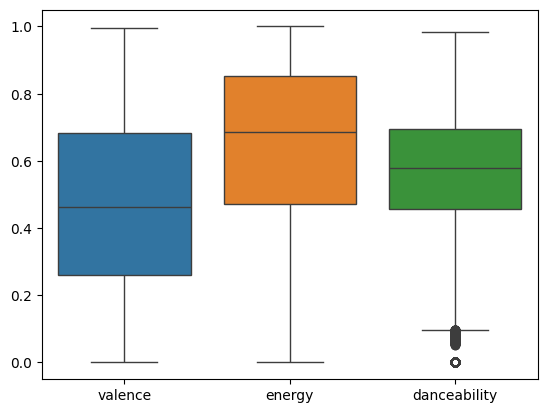

In [4]:

import seaborn as sns
sns.boxplot(data=spotify[['valence', 'energy', 'danceability']])
plt.show()



## RobustScaler ile Aykırı Değerleri Etkisizleştirme

Veri setinde bulunan uç (aykırı) değerler, özellikle istatistiksel analizler ve makine öğrenmesi modelleri açısından yanıltıcı olabilir.
Bu nedenle `valence`, `energy` ve `danceability` değişkenlerine **RobustScaler** uyguluyoruz.

Bu yöntem veriyi medyana göre merkezler ve IQR (interquartile range) kullanarak ölçekler. Böylece uç değerlerin etkisi azaltılır.

**Neden RobustScaler?**
- Aykırı değerleri veri dışına atmaz, sadece etkilerini azaltır.
- Model performansını arttırır, özellikle dağılım varsayımı olan algoritmalarda.


In [5]:

from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

spotify[['valence', 'energy', 'danceability']] = scaler.fit_transform(spotify[['valence', 'energy', 'danceability']])

spotify[['valence', 'energy', 'danceability']].head()


,valence,energy,danceability
0,0.593381,-0.586387,0.401674
1,-0.465721,-1.358639,-0.669456
2,-0.813239,-0.853403,-0.594142
3,-0.758865,-1.637173,-1.313808
4,-0.702128,-0.633508,0.158996


## Veri Tipi Kontrolü

In [6]:

spotify.dtypes


Unnamed: 0            int64
track_id             object
artists              object
album_name           object
track_name           object
popularity            int64
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
dtype: object

## Normal Dağılım Testi (Shapiro-Wilk)

In [7]:

from scipy.stats import shapiro

for col in ['valence', 'energy', 'tempo']:
    stat, p = shapiro(spotify[col])
    print(f"{col}: stat={stat:.4f}, p={p:.20f}")


valence: stat=0.9690, p=0.00000000000000000000
energy: stat=0.9458, p=0.00000000000000000000
tempo: stat=0.9872, p=0.00000000000000000000



**Not:** Elde edilen p-değerleri çok küçük çıktığı için `0.00000000000000000001` gibi bir sayı `0.000000` şeklinde gösterilir. 
Bu durum teknik bir hata değildir. Bu, analiz sonucunun istatistiksel olarak **çok anlamlı** olduğunu ve gruplar arasında güçlü farklar olduğunu gösterir.


## Varyans Eşitliği Testi (Fligner-Killeen)

In [8]:
from scipy.stats import fligner

stat, p = fligner(spotify['valence'], spotify['energy'])
print(f"Fligner-Killeen Test: stat={stat:.4f}, p={p:.20f}")

Fligner-Killeen Test: stat=141.2821, p=0.00000000000000000000


fligner() fonksiyonu, gruplar arası varyansların eşit olup olmadığını test eder.

p < 0.05 → varyanslar farklıdır → H₀ reddedilir.

p ≥ 0.05 → varyanslar eşittir → H₀ kabul edilir.

## Anket Verisini Analiz Ederek Müzik Türlerinin Ortalama Ruh Hali Etkilerini Belirleme
Aşağıdaki veri seti, bireylerin favori müzik türlerini ve onların ruhsal durumlarını (örneğin **anksiyete**, **depresyon**) içerir.

Her tür için ortalama değerler hesaplanarak, o türü dinleyenlerin genel psikolojik durumu ölçülür.

In [9]:
mxmh = pd.read_csv('mxmh_survey_results.csv')
genre_cols = [c for c in mxmh.columns if 'Frequency [' in c]
targets = ['Anxiety', 'Depression', 'Insomnia', 'OCD']
mxmh = mxmh.dropna(subset=genre_cols + targets)
for col in genre_cols:
    mxmh[col] = mxmh[col].map({'Never': 0, 'Rarely': 1, 'Sometimes': 2, 'Very frequently': 3})
genre_means = {}
for genre in genre_cols:
    avg = mxmh[mxmh[genre] > 0][targets].mean()
    genre_means[genre.replace('Frequency [','').replace(']','')] = avg
impact_df = pd.DataFrame(genre_means).T

Bu tabloda, her müzik türü için o türü dinleyen bireylerin ortalama ruh hali skorları yer almaktadır. 
| Tür | Anksiyete | Depresyon | Uykusuzluk | OCD |
|-----|-----------|------------|------------|------|
Değerler 0 ile 10 arasında değişir.

In [10]:
impact_df.head()

,Anxiety,Depression,Insomnia,OCD
Classical,5.798060,4.782187,3.798060,2.664903
Country,5.914758,4.756997,3.709924,2.823155
EDM,6.019814,5.145688,3.948718,2.863636
Folk,6.091216,5.045045,3.890766,2.743243
Gospel,5.743781,4.808458,3.850746,2.828358


## Müzik Türlerini Sağlık Etkisine Göre Otomatik Sınıflandırma
KMeans algoritmasıyla, türler `Calming`, `Neutral`, `Anxious` gibi gruplara ayrılır. Bu sınıflar, psikolojik etki sınıfımız olur.


## KMeans Kümeleme İşlemi

**KMeans** algoritması, **gözlemleri (verileri) belirli sayıda kümeye (cluster)** ayırmaya çalışan bir denetimsiz öğrenme algoritmasıdır. Bu algoritma, her veriyi **en yakın merkez noktasına** (centroid) atar ve kümelerin **içerisindeki verilerin homojenliğini** artırmayı amaçlar.

### **KMeans Algoritmasının Adımları:**

1. **Başlangıçta Kümeleri Belirleme:**
   - İlk olarak, küme sayısı (\( k \)) belirlenir. Örneğin, bu projede **3 küme** kullanıyoruz (`Calming`, `Neutral`, `Anxious`).
   
2. **Rastgele Başlangıç Noktalarını Seçme:**
   - Algoritma, **k merkezi** (centroid) rastgele seçer. Bu noktalar, her kümenin **ilk merkez noktaları**dır.

3. **Verileri Küme Merkezlerine Atama:**
   - Her gözlem (şarkı) **en yakın merkez noktası**na (centroid) atanır. Bu işlem, tüm verilerin kümelere dağılmasını sağlar.
   
4. **Yeni Küme Merkezlerinin Hesaplanması:**
   - Küme merkezleri, her kümedeki verilerin **ortalaması** alınarak yeniden hesaplanır. Bu, her kümenin yeni **merkezine** yol açar.
   
5. **Adımların Tekrarı:**
   - Bu adımlar, kümelerin **sabitlenene kadar** (yani, kümeler değişmeyene kadar) tekrarlanır.

### **KMeans Kümeleme Uygulaması:**

Bu projede, **MxMH veri setindeki müzik türleri** kullanılarak, **sağlık etkisi sınıflarını** oluşturmak için KMeans kümeleme algoritması uygulandı. Sağlık etkisi sınıfları:
- **Calming**: Düşük anksiyete etkisi
- **Neutral**: Orta düzeyde etki
- **Anxious**: Yüksek anksiyete etkisi

**KMeans algoritması** kullanılarak türler sağlık etkilerine göre şu şekilde gruplandırıldı:
- **Calming (Rahatlatıcı)**: Şarkılar, düşük anksiyete düzeyine sahip.
- **Neutral (Nötr)**: Orta düzeyde ruhsal etki.
- **Anxious (Kaygı Verici)**: Yüksek anksiyete düzeyi.

### **KMeans Kümeleme Sonuçları:**

Her müzik türü, **KMeans algoritması** ile doğru **sağlık etkisi sınıfına** atanmış oldu. Bu sınıflar, şarkılara ait **müzikal özelliklere** (valence, energy, tempo, vb.) göre belirlendi.


In [11]:
scaler = StandardScaler()
from sklearn.cluster import KMeans
scaled = scaler.fit_transform(impact_df)
kmeans = KMeans(n_clusters=3, random_state=42).fit(scaled)
impact_df['cluster'] = kmeans.labels_
order = impact_df.groupby('cluster')['Anxiety'].mean().sort_values().index.tolist()
label_map = {order[0]: 'Calming', order[1]: 'Neutral', order[2]: 'Anxious'}
impact_df['health_effect'] = impact_df['cluster'].map(label_map)
impact_df[['Anxiety', 'Depression', 'Insomnia', 'OCD', 'health_effect']]

,Anxiety,Depression,Insomnia,OCD,health_effect
Classical,5.798060,4.782187,3.798060,2.664903,Calming
Country,5.914758,4.756997,3.709924,2.823155,Neutral
EDM,6.019814,5.145688,3.948718,2.863636,Anxious
Folk,6.091216,5.045045,3.890766,2.743243,Anxious
Gospel,5.743781,4.808458,3.850746,2.828358,Neutral
Hip hop,5.923423,5.068468,3.826126,2.742342,Anxious
Jazz,5.809474,4.849474,3.767368,2.585263,Calming
K pop,5.973438,4.879688,3.759375,2.689062,Anxious
Latin,5.680887,4.916382,3.967577,2.515358,Calming
Lofi,6.007675,4.963816,3.850877,2.742325,Anxious


## Spotify Şarkılarına Tür Bazlı Etki Sınıfı Atama
Spotify'daki her şarkı `track_genre` kolonu üzerinden yukarıdaki sınıflardan birine atanır. Böylece her şarkının sağlık etkisi etiketi olur.

In [12]:
spotify['normalized_genre'] = spotify['track_genre'].str.capitalize()
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

features = ['valence', 'energy', 'danceability', 'tempo', 'loudness']
X = spotify[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
spotify['cluster'] = kmeans.fit_predict(X_scaled)

cluster_order = spotify.groupby('cluster')['valence'].mean().sort_values().index.tolist()
label_map = {
    cluster_order[0]: 'Anxious',
    cluster_order[1]: 'Neutral',
    cluster_order[2]: 'Calming'
}
spotify['health_effect'] = spotify['cluster'].map(label_map)

## Etki Sınıfı Dağılımı
Aşağıdaki grafik, kaç şarkının hangi sağlık etkisi sınıfına ait olduğunu gösterir.

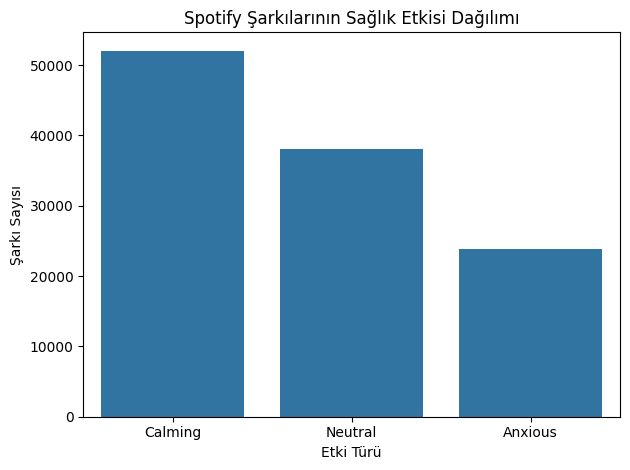

In [13]:
sns.countplot(x='health_effect', data=spotify, order=['Calming', 'Neutral', 'Anxious'])
plt.title('Spotify Şarkılarının Sağlık Etkisi Dağılımı')
plt.xlabel('Etki Türü')
plt.ylabel('Şarkı Sayısı')
plt.tight_layout()
plt.show()

## Naive Bayes ile Olasılıksal Sınıflandırma
Aşağıdaki model, müziksel özelliklere göre şarkının sağlık etkisini **olasılık teorisiyle** tahmin eder.

Özellikler: valence, energy, danceability, tempo, loudness, vb.


## Naive Bayes Modeli ve Kullanılan Özellikler

Naive Bayes modeli, Bayes teoremine dayalı olarak çalışır. Bu model, müzikal özellikler (valence, energy, tempo vb.) kullanarak sağlık etkisi sınıfını tahmin eder.

### Kullanılan Özellikler (Kolonlar):

- **`valence`**: Şarkının **pozitiflik** (olumlu hissettirme) düzeyi.
- **`energy`**: Şarkının **enerjik** olma düzeyi.
- **`danceability`**: Şarkının **dans edilebilirlik** düzeyi.
- **`acousticness`**: Şarkının **akustik** olma oranı.
- **`tempo`**: Şarkının **tempo** (BPM) değeri.
- **`instrumentalness`**: Şarkının **sözsüzlük** derecesi.
- **`loudness`**: Şarkının **ses yüksekliği** (desibel cinsinden).

### Hedef Kolon (Y):

- **`health_effect`**: Bu kolon, Naive Bayes modelinin tahmin edeceği sağlık etkisi sınıfıdır. Sağlık etkisi sınıfları genellikle şu şekilde belirlenmiştir:
  - **Calming**: Rahatlatıcı etki
  - **Anxious**: Kaygı verici etki
  - **Neutral**: Nötr etki

### Bayes Teoremi:
Naive Bayes modeli, Bayes teoremine dayanarak çalışır. Şu formüle dayanır:
\[
P(C | X) = {P(X | C) . P(C)} / {P(X)}
\]
Burada:
- \( C \): **Sağlık etkisi sınıfı** (örneğin: Calming, Anxious, Neutral)
- \( X \): Şarkının **özellikleri** (örneğin: `valence`, `energy`, `tempo`, vb.)
- \( P(C | X) \): Verilen özellikler \( X \) için sınıf \( C \)'nin olasılığı
- \( P(X | C) \): Sağlık etkisi sınıfı \( C \)'ye bağlı olarak \( X \)'in gözlemlenme olasılığı
- \( P(C) \): Sınıfın genel olasılığı (örneğin, tüm **Calming** şarkılarının oranı)
- \( P(X) \): Özelliklerin gözlemlenme olasılığı

Model, **Spotify şarkılarının müzikal özellikleri** ve **sağlık etkisi sınıflarını** kullanarak tahmin yapar ve **olasılıkları hesaplar**.


In [14]:
features = ['valence', 'energy', 'danceability', 'acousticness', 'tempo', 'instrumentalness', 'loudness']
X = spotify[features]
y = spotify['health_effect']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     Anxious       0.87      0.92      0.89      7156
     Calming       0.92      0.92      0.92     15551
     Neutral       0.91      0.88      0.89     11493

    accuracy                           0.91     34200
   macro avg       0.90      0.91      0.90     34200
weighted avg       0.91      0.91      0.91     34200



## Olasılık Tahmini Örneği
Bir şarkının özellikleri verildiğinde, her sınıfa ait olma olasılığı aşağıdaki gibi hesaplanır:

In [15]:
sample = X_test.iloc[0:1]
probs = model.predict_proba(sample)[0]
for cls, p in zip(model.classes_, probs):
    print(f"P({cls} | özellikler) = {p:.20f}")

P(Anxious | özellikler) = 0.00085574507499829163
P(Calming | özellikler) = 0.00051727274417038118
P(Neutral | özellikler) = 0.99862698218083101320


## Kullanıcı Girişi ile Tahmin Aracı
Aşağıya müzik özelliklerini girerek şarkının hangi sağlık etkisine sahip olabileceğini tahmin edebilirsiniz.

In [16]:
def predict_effect(valence, energy, danceability, acousticness, tempo, instrumentalness, loudness):
    input_data = pd.DataFrame([[valence, energy, danceability, acousticness, tempo, instrumentalness, loudness]],
                              columns=features)
    prob = model.predict_proba(input_data)[0]
    for cls, p in zip(model.classes_, prob):
        print(f"P({cls} | özellikler) = {p:.20f}")


predict_effect(valence=0.8, energy=0.7, danceability=0.9, acousticness=0.1, tempo=115, instrumentalness=0.0, loudness=-4)

P(Anxious | özellikler) = 0.00000001021245817001
P(Calming | özellikler) = 0.99197233606755064184
P(Neutral | özellikler) = 0.00802765371999084563


In [17]:
import numpy as np
import matplotlib.pyplot as plt

spotify.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,normalized_genre,cluster,health_effect
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.401674,-0.586387,...,0.0322,0.000001,0.3580,0.593381,87.917,4,acoustic,Acoustic,1,Calming
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,-0.669456,-1.358639,...,0.9240,0.000006,0.1010,-0.465721,77.489,4,acoustic,Acoustic,2,Anxious
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,-0.594142,-0.853403,...,0.2100,0.000000,0.1170,-0.813239,76.332,4,acoustic,Acoustic,2,Anxious
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,-1.313808,-1.637173,...,0.9050,0.000071,0.1320,-0.758865,181.740,3,acoustic,Acoustic,2,Anxious
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.158996,-0.633508,...,0.4690,0.000000,0.0829,-0.702128,119.949,4,acoustic,Acoustic,2,Anxious


## Korelasyon Analizi

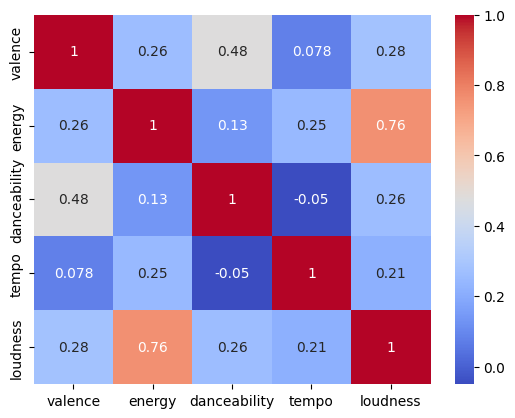

In [18]:

import matplotlib.pyplot as plt
corr = spotify[['valence', 'energy', 'danceability', 'tempo', 'loudness']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()


## PCA Analizi (Principal Component Analysis)

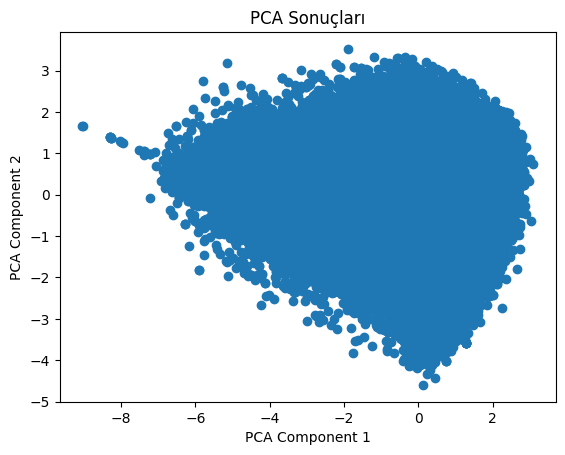

In [19]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaled_data = scaler.fit_transform(spotify[['valence', 'energy', 'danceability', 'tempo', 'loudness']])
pca = PCA(n_components=2)
pca_results = pca.fit_transform(scaled_data)

plt.scatter(pca_results[:,0], pca_results[:,1])
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Sonuçları')
plt.show()



## Ki-Kare Testi

Bu test, örneğin `track_genre` ile `health_effect` gibi **iki kategorik değişkenin** birbirine bağımlı olup olmadığını test eder.  
Ki-kare testine göre `p < 0.05` ise değişkenler arasında **istatistiksel olarak anlamlı bir ilişki vardır**.

Aşağıdaki grafik, bu ilişkiyi kategoriler arasında bir **heatmap** ile gösterir.


Chi2 = 62622.3633, p = 0.00000000000000000000000000000000000000000000000000


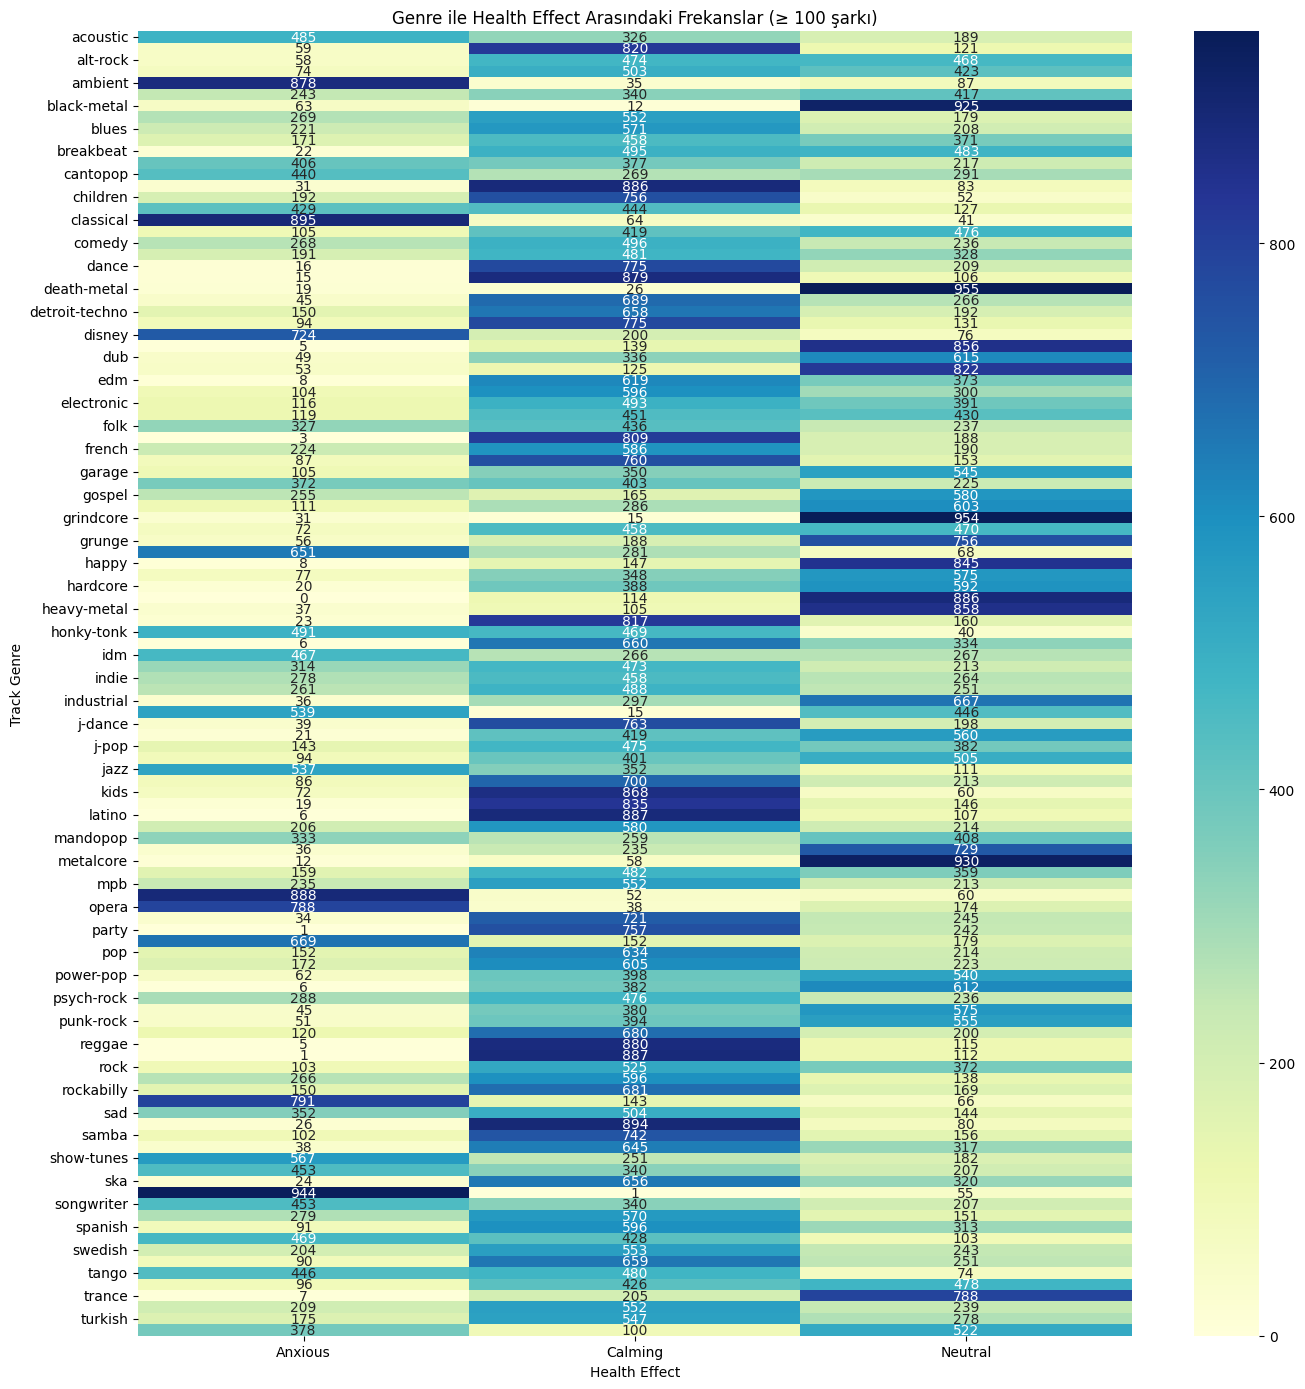

In [20]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

contingency = pd.crosstab(spotify['track_genre'], spotify['health_effect'])

chi2, p, dof, expected = chi2_contingency(contingency)
print(f"Chi2 = {chi2:.4f}, p = {p:.50f}")

row_totals = contingency.sum(axis=1)
filtered_contingency = contingency[row_totals > 100]

plt.figure(figsize=(14, 14))
sns.heatmap(filtered_contingency, annot=True, fmt='d', cmap='YlGnBu')

plt.title('Genre ile Health Effect Arasındaki Frekanslar (≥ 100 şarkı)')
plt.ylabel('Track Genre')
plt.xlabel('Health Effect')
plt.tight_layout()
plt.show()



**Not:** Elde edilen p-değerleri çok küçük çıktığı için `0.00000000000000000001` gibi bir sayı `0.000000` şeklinde gösterilir. 
Bu durum teknik bir hata değildir. Bu, analiz sonucunun istatistiksel olarak **çok anlamlı** olduğunu ve gruplar arasında güçlü farklar olduğunu gösterir.


## Mann-Whitney U Testi

In [21]:

from scipy.stats import mannwhitneyu

calming = spotify[spotify['health_effect'] == 'Calming']['valence']
anxious = spotify[spotify['health_effect'] == 'Anxious']['valence']
stat, p = mannwhitneyu(calming, anxious)
print(f"Mann-Whitney U Test: stat={stat:.4f}, p={p:.20f}")


Mann-Whitney U Test: stat=1142006586.0000, p=0.00000000000000000000
